
Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [1]:
%matplotlib inline
import torch
import torchvision
from torchsummary import summary
import torch.nn as nn
import transforms
import cuda
from loader import dataloader
from loader import imshow
from model import Net
from train import train
from train import val
from results import class_wise_accuracies
from results import plot_graph

In [3]:
class Args:
    # Training
    # ========
    random_seed = 1
    epochs = 20
    learning_rate = 0.01
    momentum = 0.9
    lr_step_size = 25
    lr_gamma = 0.1

    # Evaluation
    # ==========
    sample_count = 25
    gpu_batch_size = 128
    cpu_batch_size  = 64
    num_workers = 4

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].  

## Downloading dataset

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms.transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transforms.transform)

Files already downloaded and verified
Files already downloaded and verified


## Setting device

In [5]:
cuda, device = cuda.init_cuda(Args.random_seed)
cuda

CUDA Available? True
Device: cuda


True

## Loading Data

In [6]:
train_loader, test_loader = dataloader(trainset, testset, Args.gpu_batch_size, Args.cpu_batch_size, Args.num_workers, cuda)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Let us show some of the training images, for fun.



plane dog deer deer truck


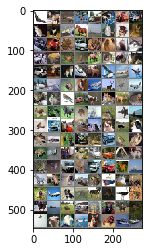

In [7]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%s' % classes[labels[j]] for j in range(5)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane


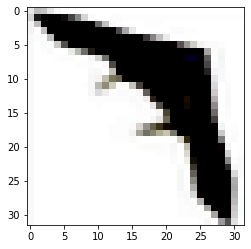

In [10]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(np.transpose(images[0].numpy().squeeze()))
print(''.join('%s' % classes[labels[0]]))

## Model and Parameters


In [8]:
print(device)
model = Net().to(device)
summary(model,input_size = (3,32,32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
           Dropout-3           [-1, 16, 32, 32]               0
              ReLU-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,640
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
         MaxPool2d-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 32, 16, 16]           9,216
           Conv2d-10           [-1, 64, 16, 16]          18,432
      BatchNorm2d-11           [-1, 64, 16, 16]             128
          Dropout-12           [-1, 64, 16, 16]               0
             ReLU-13           [-1, 64, 16, 16]               0
           Conv2d-14           [-1

### Loss function and Optimizer
Let's use a Classification Cross-Entropy loss and SGD with momentum.

In [9]:
criterion = nn.CrossEntropyLoss()

## Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [10]:
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
model =  Net().to(device)

losses = []
accuracies = []
correct_samples = []
incorrect_samples = []

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.3)
last_epoch = False

for epoch in range(1, Args.epochs + 1):
    print(f'Epoch {epoch}:')
    if epoch == Args.epochs:
        last_epoch = True
    train(model, train_loader, device, optimizer, criterion)
    scheduler.step()
    val(
        model, test_loader, device, criterion, losses, accuracies,
        correct_samples, incorrect_samples, Args.sample_count, last_epoch=last_epoch
    )

Epoch 1:


Loss=1.23 Batch_ID=390 Accuracy=48.70: 100%|█████████████████████████████████████████| 391/391 [01:05<00:00,  5.97it/s]



Validation set: Average loss: 0.0090, Accuracy: 5995/10000 (59.95%)

Epoch 2:


Loss=1.06 Batch_ID=390 Accuracy=66.47: 100%|█████████████████████████████████████████| 391/391 [01:03<00:00,  6.15it/s]



Validation set: Average loss: 0.0074, Accuracy: 6660/10000 (66.60%)

Epoch 3:


Loss=0.77 Batch_ID=390 Accuracy=72.50: 100%|█████████████████████████████████████████| 391/391 [01:03<00:00,  6.18it/s]



Validation set: Average loss: 0.0066, Accuracy: 7119/10000 (71.19%)

Epoch 4:


Loss=0.68 Batch_ID=390 Accuracy=75.65: 100%|█████████████████████████████████████████| 391/391 [01:08<00:00,  5.68it/s]



Validation set: Average loss: 0.0055, Accuracy: 7618/10000 (76.18%)

Epoch 5:


Loss=0.50 Batch_ID=390 Accuracy=77.92: 100%|█████████████████████████████████████████| 391/391 [01:08<00:00,  5.67it/s]



Validation set: Average loss: 0.0059, Accuracy: 7496/10000 (74.96%)

Epoch 6:


Loss=0.55 Batch_ID=390 Accuracy=79.91: 100%|█████████████████████████████████████████| 391/391 [01:12<00:00,  5.36it/s]



Validation set: Average loss: 0.0055, Accuracy: 7671/10000 (76.71%)

Epoch 7:


Loss=0.50 Batch_ID=390 Accuracy=83.66: 100%|█████████████████████████████████████████| 391/391 [01:09<00:00,  5.61it/s]



Validation set: Average loss: 0.0043, Accuracy: 8178/10000 (81.78%)

Epoch 8:


Loss=0.33 Batch_ID=390 Accuracy=84.57: 100%|█████████████████████████████████████████| 391/391 [01:14<00:00,  5.22it/s]



Validation set: Average loss: 0.0043, Accuracy: 8184/10000 (81.84%)

Epoch 9:


Loss=0.35 Batch_ID=390 Accuracy=84.90: 100%|█████████████████████████████████████████| 391/391 [01:12<00:00,  5.41it/s]



Validation set: Average loss: 0.0042, Accuracy: 8157/10000 (81.57%)

Epoch 10:


Loss=0.39 Batch_ID=390 Accuracy=85.53: 100%|█████████████████████████████████████████| 391/391 [01:14<00:00,  5.25it/s]



Validation set: Average loss: 0.0043, Accuracy: 8158/10000 (81.58%)

Epoch 11:


Loss=0.45 Batch_ID=390 Accuracy=85.91: 100%|█████████████████████████████████████████| 391/391 [01:14<00:00,  5.24it/s]



Validation set: Average loss: 0.0041, Accuracy: 8244/10000 (82.44%)

Epoch 12:


Loss=0.56 Batch_ID=390 Accuracy=86.36: 100%|█████████████████████████████████████████| 391/391 [01:16<00:00,  5.09it/s]



Validation set: Average loss: 0.0044, Accuracy: 8152/10000 (81.52%)

Epoch 13:


Loss=0.32 Batch_ID=390 Accuracy=87.85: 100%|█████████████████████████████████████████| 391/391 [01:17<00:00,  5.06it/s]



Validation set: Average loss: 0.0039, Accuracy: 8313/10000 (83.13%)

Epoch 14:


Loss=0.38 Batch_ID=390 Accuracy=88.44: 100%|█████████████████████████████████████████| 391/391 [01:17<00:00,  5.06it/s]



Validation set: Average loss: 0.0040, Accuracy: 8305/10000 (83.05%)

Epoch 15:


Loss=0.21 Batch_ID=390 Accuracy=88.46: 100%|█████████████████████████████████████████| 391/391 [01:18<00:00,  4.96it/s]



Validation set: Average loss: 0.0040, Accuracy: 8327/10000 (83.27%)

Epoch 16:


Loss=0.55 Batch_ID=390 Accuracy=88.65: 100%|█████████████████████████████████████████| 391/391 [03:29<00:00,  2.29it/s]



Validation set: Average loss: 0.0041, Accuracy: 8300/10000 (83.00%)

Epoch 17:


Loss=0.27 Batch_ID=390 Accuracy=88.79: 100%|█████████████████████████████████████████| 391/391 [03:29<00:00,  2.28it/s]



Validation set: Average loss: 0.0040, Accuracy: 8305/10000 (83.05%)

Epoch 18:


Loss=0.42 Batch_ID=390 Accuracy=88.91: 100%|█████████████████████████████████████████| 391/391 [03:28<00:00,  2.29it/s]



Validation set: Average loss: 0.0040, Accuracy: 8340/10000 (83.40%)

Epoch 19:


Loss=0.36 Batch_ID=390 Accuracy=89.48: 100%|█████████████████████████████████████████| 391/391 [01:57<00:00,  3.32it/s]



Validation set: Average loss: 0.0040, Accuracy: 8359/10000 (83.59%)

Epoch 20:


Loss=0.34 Batch_ID=390 Accuracy=89.63: 100%|█████████████████████████████████████████| 391/391 [00:47<00:00,  8.20it/s]



Validation set: Average loss: 0.0040, Accuracy: 8359/10000 (83.59%)



## Graph Visualisation

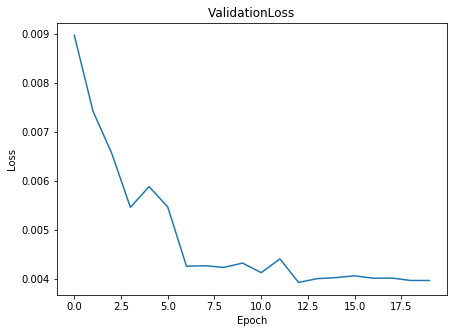

In [11]:
plot_graph(losses,'Loss')

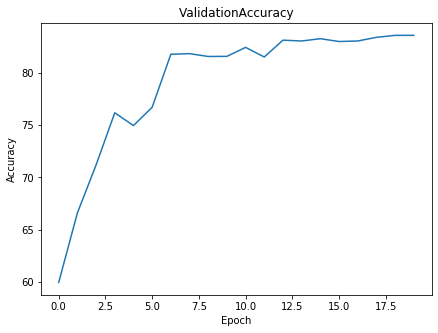

In [12]:
plot_graph(accuracies, 'Accuracy')

## Class-wise Accuracy distributions

In [15]:
#test_loader.to(self.device)
class_wise_accuracies(model, test_loader, device, classes)

Accuracy of plane : 83 %
Accuracy of   car : 93 %
Accuracy of  bird : 75 %
Accuracy of   cat : 71 %
Accuracy of  deer : 83 %
Accuracy of   dog : 72 %
Accuracy of  frog : 88 %
Accuracy of horse : 86 %
Accuracy of  ship : 94 %
Accuracy of truck : 87 %
